In [1]:
!pip install torchtext==0.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from torchtext.data import Field, TabularDataset, BucketIterator,LabelField
from tqdm.notebook import tqdm
from torchtext.vocab import GloVe

# Essential libraries
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
print(torch.__version__)

2.0.1+cu118


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Load the original dataset
df = pd.read_csv('missom_coded_v1_santosh.csv')
df = df.rename(columns={'label_minority_stress': 'label'})
df = df[['text', 'label']]

df.info()
df.label.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5789 entries, 0 to 5788
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5789 non-null   object
 1   label   5789 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB


0    4551
1    1238
Name: label, dtype: int64

In [5]:
# Split the dataset into train, test, and validation sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Save the dataframes to CSV files
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)
val_df.to_csv('valid.csv', index=False)




In [6]:
# SEED = 1234
# torch.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True

TEXT = Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  include_lengths = True, batch_first = True)

LABEL = LabelField(sequential = False, use_vocab = False, batch_first = True,dtype = torch.float)

In [7]:
# Load the data
train_data,valid_data, test_data = TabularDataset.splits(
    path= '/content/',
    train='train.csv',
    validation='valid.csv',
    test='test.csv',
    format='csv',
    fields=[('text', TEXT), ('label', LABEL)],
    skip_header=True
)
print('Number of training examples: {}'.format(len(train_data)))
print('Number of Validation examples: {}'.format(len(valid_data)))
print('Number of testing examples: {}'.format(len(test_data)))
print(train_data[0])

Number of training examples: 3704
Number of Validation examples: 927
Number of testing examples: 1158


In [8]:
# TEXT.build_vocab(train_data, min_freq = 3)

MAX_VOCAB_SIZE = 25000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.38MB/s]                           
100%|█████████▉| 399999/400000 [00:18<00:00, 22152.04it/s]


In [9]:
BATCH_SIZE = 64



train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=lambda x: len(x.text),
    sort_within_batch = True
    )

In [10]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class LSTM(nn.Module):

    def __init__(self, dimension = 128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(TEXT.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size = 300,
                            hidden_size = dimension,
                            num_layers = 1,
                            batch_first = True,
                            bidirectional = True)
        self.drop = nn.Dropout(p = 0.5)

        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)
        # print(text_len)
        text_len = text_len.view(-1)
        # print(text_len)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first = True, enforce_sorted = False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first = True)
        
        indices = torch.arange(0, text.size(0))  # Create an index tensor for valid elements
        out_forward = output[indices, text_len - 1, :self.dimension] 
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

In [11]:
# Save and load functions
def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


In [12]:
# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Training function
def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iterator,
          valid_loader = valid_iterator,
          num_epochs = 5,
          eval_every = len(train_iterator) // 2,
          file_path = "/content/",
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []
    
    # initialize predicted values
    y_pred = []
    y_true = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for batch in train_loader: 

            optimizer.zero_grad()
            text, text_len = batch.text
            labels = batch.label

            # labels = labels.to(device)
            # text = text.to(device)
            text_len = text_len.to('cpu')
            output = model(text, text_len)
            
            threshold = 0.5
            output_1 = (output > threshold).int()
            y_pred.extend(output_1.tolist())
            y_true.extend(labels.tolist())

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for batch in valid_loader:
                      text, text_len = batch.text
                      labels = batch.label

                      # labels = labels.to(device)
                      # text = text.to(device)
                      text_len = text_len.to('cpu')
                      output = model(text, text_len)

                      loss = criterion(output, labels)
                      valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    print('Finished Training!')


In [13]:
# Training
import torch.optim as optim
# Call the model
model = LSTM().to(device)

# Create an Adam optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# Train the model
train(model = model, optimizer = optimizer, num_epochs = 10)

Epoch [1/10], Step [29/580], Train Loss: 0.5539, Valid Loss: 0.5348
Model saved to ==> /content//model.pt
Model saved to ==> /content//metrics.pt
Epoch [1/10], Step [58/580], Train Loss: 0.5450, Valid Loss: 0.5200
Model saved to ==> /content//model.pt
Model saved to ==> /content//metrics.pt
Epoch [2/10], Step [87/580], Train Loss: 0.5245, Valid Loss: 0.5147
Model saved to ==> /content//model.pt
Model saved to ==> /content//metrics.pt
Epoch [2/10], Step [116/580], Train Loss: 0.4528, Valid Loss: 0.5123
Model saved to ==> /content//model.pt
Model saved to ==> /content//metrics.pt
Epoch [3/10], Step [145/580], Train Loss: 0.4367, Valid Loss: 0.5104
Model saved to ==> /content//model.pt
Model saved to ==> /content//metrics.pt
Epoch [3/10], Step [174/580], Train Loss: 0.4409, Valid Loss: 0.5263
Epoch [4/10], Step [203/580], Train Loss: 0.3239, Valid Loss: 0.5775
Epoch [4/10], Step [232/580], Train Loss: 0.3943, Valid Loss: 0.5360
Epoch [5/10], Step [261/580], Train Loss: 0.2740, Valid Loss:

Code from Cory

Model loaded from <== /content//metrics.pt


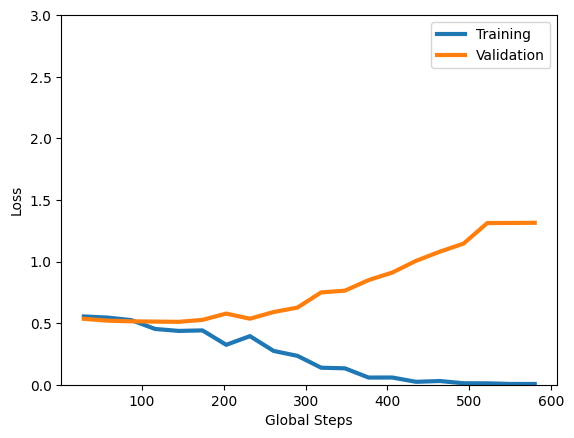

In [14]:
# VISUALIZE LOSS
import warnings
warnings.filterwarnings('ignore') 

# Create the plot
train_loss_list, valid_loss_list, global_steps_list = load_metrics('/content/' + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label = 'Training', linewidth = 3)
plt.plot(global_steps_list, valid_loss_list, label = 'Validation', linewidth = 3)
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.ylim([0, 3])
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"

# Save and print the plot
plt.savefig('/content/' + 'lstm_loss_2.png')

In [15]:
###Evaluate in Test data
# initialize predicted values
y_pred = []
y_true = []
model.eval()
criterion = nn.BCELoss()
valid_running_loss = 0.0
# validation loop
for batch in test_iterator:
    text, text_len = batch.text
    labels = batch.label

    # labels = labels.to(device)
    # text = text.to(device)
    text_len = text_len.to('cpu')
    output = model(text, text_len)

    threshold = 0.5
    output_1 = (output > threshold).int()
    y_pred.extend(output_1.tolist())
    y_true.extend(labels.tolist())

    loss = criterion(output, labels)
    valid_running_loss += loss.item()

print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

Classification Report:
              precision    recall  f1-score   support

           1     0.3636    0.2072    0.2640       251
           0     0.8039    0.8997    0.8491       907

    accuracy                         0.7496      1158
   macro avg     0.5838    0.5534    0.5565      1158
weighted avg     0.7085    0.7496    0.7223      1158

